In [1]:
# Set target type -> REMOVE AND ADAPT AT APPROPRIATE LOCATION FOR A USE-CASE
%reset -f
TYPE = "CLASS"
#TYPE = "REGR"
#TYPE = "MULTICLASS"

# Where am I?
import os
os.getcwd()
#os.chdir("..")


'C:\\My\\Projekte\\PredMod_Template\\notebooks'

In [2]:
#######################################################################################################################-
#|||| Initialize ||||----
#######################################################################################################################-

#%config IPCompleter.greedy=True

# Packages
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
import dill
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_validate, RepeatedKFold, learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgbm

# Plot options
%matplotlib notebook
sns.set(style="whitegrid")
plt.ioff()

# Parameter
dataloc = "../data/"
plotloc = "../output/"

# Functions
def setdiff(a, b):
    return [x for x in a if x not in set(b)]

def get_plot_distr_metr(df_plot, features, misspct):
    fig, ax = plt.subplots(1 + len(features) // 3, 3)
    for i in range(len(features)):
        axact = ax.flat[i]
        sns.distplot(df.loc[df_plot.target == "Y", features[i]].dropna(), color = "red", label = "Y", ax = axact)
        sns.distplot(df.loc[df_plot.target == "N", features[i]].dropna(), color = "blue", label = "N", ax = axact)
        axact.set_title(features[i])
        axact.set_ylabel("density")
        axact.set_xlabel(features[i] + "(NA: " + str(round(misspct[features[i]] * 100, 1)) + "%)")
    ax.flat[0].legend(title = "Target", loc = "best")
    fig.tight_layout()
    return(fig)

def get_plot_distr_nomi(df_plot, features):
    fig, ax = plt.subplots(len(features) // 3, 3)
    for i in range(len(features)):
        df_tmp = pd.DataFrame({"h": df_plot.groupby(features[i])["target_num"].mean(), 
                               "w": df_plot.groupby(features[i]).size()}).reset_index()
        df_tmp["w"] = df_tmp["w"]/max(df_tmp["w"])
        axact = ax.flat[i]
        sns.barplot(df_tmp.h, df_tmp[features[i]], orient = "h", color = "coral", ax = axact)
        axact.set_xlabel("Proportion Target = Y");
        axact.axvline(np.mean(df_plot.target_num), ls = "dotted", color = "black")
        for bar,width in zip(axact.patches, df_tmp.w):
            bar.set_height(width)
    fig.tight_layout()
    return(fig)


#exec(open("./0_init.py").read())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#######################################################################################################################-
#|||| ETL ||||----
#######################################################################################################################-

# Read data --------------------------------------------------------------------------------------------------------

if TYPE == "CLASS":
    df_orig = pd.read_csv(dataloc + "titanic.csv")
if TYPE in ["REGR","MULTICLASS"]:
    df_orig = pd.read_csv(dataloc + "AmesHousing.txt", sep = "\t") 
    df_orig.columns = [x.replace(" ","_") for x in df_orig.columns.values]

df_orig

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1st,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.549999,E12,Southampton,3,NaN,"New York, NY"
6,1st,1,"Andrews, Miss. Kornelia Theodos",female,63.0000,1,0,13502,77.958298,D7,Southampton,10,NaN,"Hudson, NY"
7,1st,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.000000,A36,Southampton,NaN,NaN,"Belfast, NI"
8,1st,1,"Appleton, Mrs. Edward Dale (Cha",female,53.0000,2,0,11769,51.479198,C101,Southampton,D,NaN,"Bayside, Queens, NY"
9,1st,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.504200,NaN,Cherbourg,NaN,22.0,"Montevideo, Uruguay"


In [4]:
# Check some stuff
df_orig.describe()
df_orig.describe(include = ["object"])
pd.concat([df_orig[catname].value_counts()[:4].reset_index().rename(columns = {"index": catname, catname: "#"+catname})
                     for catname in df_orig.select_dtypes(["object"]).columns.values], axis = 1).style.bar(color='grey')
if TYPE == "REGR":
    plt.hist(df_orig.SalePrice, 30)
    plt.hist(log(df_orig.SalePrice), 30)

,survived,age,sibsp,parch,fare,body
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.486055,14.413500,1.041658,0.865560,51.758669,97.696922
min,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,1.000000,80.000000,8.000000,9.000000,512.329224,328.000000


,pclass,name,sex,ticket,cabin,embarked,boat,home.dest
count,1309,1309,1309,1309,295,1307,486,745
unique,3,1307,2,929,186,3,27,368
top,3rd,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,Southampton,13,"New York, NY"
freq,709,2,843,11,6,914,39,64


,pclass,#pclass,name,#name,sex,#sex,ticket,#ticket,cabin,#cabin,embarked,#embarked,boat,#boat,home.dest,#home.dest
0,3rd,709,"Kelly, Mr. James",2,male,843,CA. 2343,11,C23 C25 C27,6,Southampton,914,13,39,"New York, NY",64
1,1st,323,"Connolly, Miss. Kate",2,female,466,1601,8,G6,5,Cherbourg,270,C,38,London,14
2,2nd,277,"Penasco y Castellana, Mr. Victo",1,nan,nan,CA 2144,8,B57 B59 B63 B66,5,Queenstown,123,15,37,"Montreal, PQ",10
3,nan,nan,"Ryan, Mr. Edward",1,nan,nan,S.O.C. 14879,7,F33,4,nan,nan,14,33,"Paris, France",9


In [5]:
# "Save" orignial data
df = df_orig.copy() 

## 1.2 Feature engineering

In [6]:
# Feature engineering -------------------------------------------------------------------------------------------------------------

if TYPE == "CLASS": 
    df["deck"] = df["cabin"].str[:1]
    df.deck.describe()
    df.deck.value_counts()[:4]
    # also possible: df$familysize = df$sibsp + df$parch as well as something with title from name
#if TYPE in ["REGR","MULTICLASS"]:
    # number of rooms, sqm_per_room, ...


count     295
unique      8
top         C
freq       94
Name: deck, dtype: object

C    94
B    65
D    46
E    41
Name: deck, dtype: int64

In [7]:
# Define target and train/test-fold ----------------------------------------------------------------------------------

# Target
if TYPE == "CLASS":
    df["target"] = np.where(df.survived == 0, "N", "Y") 
    df["target_num"] = df.target.map({"N":0, "Y":1})
if TYPE == "REGR":
    df["target"] = df.SalePrice
#todo
#if TYPE == "MULTICLASS":
    #df$target = as.factor(paste0("Cat_", as.numeric(cut(df.orig$SalePrice, c(-Inf,quantile(df.orig$SalePrice, c(.333,.666)),Inf)))))
display(df.target.describe())

# Train/Test fold: usually split by time
df["fold"] = "train"
df.loc[df.sample(frac = 0.3, random_state = 123).index, "fold"] = "test"
df.fold.value_counts()

count     1309
unique       2
top          N
freq       809
Name: target, dtype: object

train    916
test     393
Name: fold, dtype: int64

In [8]:
#######################################################################################################################-
#|||| Metric variables: Explore and adapt ||||----
#######################################################################################################################-

# Define metric covariates -------------------------------------------------------------------------------------

if TYPE == "CLASS":
    metr = ["age","fare"]
if TYPE in ["REGR","MULTICLASS"]:
    metr = ["Lot_Frontage","Lot_Area","Year_Built","Year_RemodAdd","Mas_Vnr_Area","BsmtFin_SF_1","BsmtFin_SF_2",
            "Bsmt_Unf_SF","Total_Bsmt_SF","first_Flr_SF","second_Flr_SF","Low_Qual_Fin_SF","Gr_Liv_Area",
            "Garage_Yr_Blt","Garage_Area","Wood_Deck_SF","Open_Porch_SF","Enclosed_Porch","threeSsn_Porch","Screen_Porch",
            "Pool_Area","Misc_Val"]
    #todo: df[metr] = map(df[metr], ~ na_if(., 0)) #zeros are always missing here
df[metr].describe()

,age,fare
count,1046.000000,1308.000000
mean,29.881135,33.295479
std,14.413500,51.758669
min,0.166700,0.000000
25%,21.000000,7.895800
50%,28.000000,14.454200
75%,39.000000,31.275000
max,80.000000,512.329224


In [9]:
# Create nominal variables for all metric variables (for linear models)  -------------------------------

# Bin by quantile
metr_binned = [x + "_BINNED_" for x in metr]
df[metr_binned] = df[metr].apply(lambda x: pd.qcut(x, 10).astype(str))

# Convert missings to own level ("(Missing)")
df[metr_binned] = df[metr_binned].fillna("(missing)")
df[metr_binned].describe()
#{print(df[x].value_counts()[:11]) for x in metr_binned}

# Remove binned variables with just 1 bin
onebin = [x for x in metr_binned if df[x].value_counts().size == 1]
onebin

,age_BINNED_,fare_BINNED_
count,1309,1309
unique,11,11
top,nan,"(7.854, 8.05]"
freq,263,146


[]

In [10]:
# Missings + Outliers + Skewness -------------------------------------------------------------------------------------

# Remove covariates with too many missings from metr 
misspct = df[metr].isnull().mean().round(3) #misssing percentage
misspct.sort_values(ascending = False) #view in descending order

# Remove variables with too many missings from metr-set
remove = misspct[misspct > 0.95].index.values.tolist() #vars to remove
print(remove)
metr = setdiff(metr, remove) #adapt metadata
metr_binned = setdiff(metr_binned, [x + "_BINNED_" for x in remove]) #keep "binned" version in sync

age     0.201
fare    0.001
dtype: float64

[]


<IPython.core.display.Javascript object>


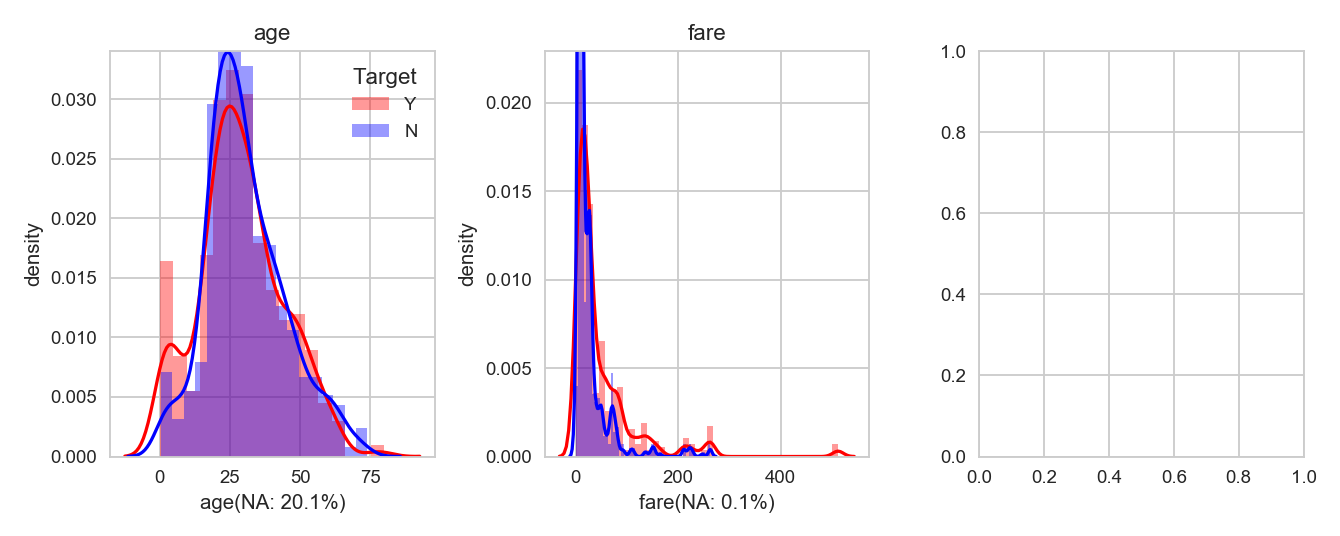

In [11]:
# Check for outliers and skewness
plt.rcParams['figure.figsize'] = (10.0, 4.0)
fig = get_plot_distr_metr(df, metr, misspct)
fig

In [12]:
# Winsorize
df[metr] = df[metr].apply(lambda x: winsorize(x, (0.05))) #hint: one might want to plot again before deciding for log-trafo
df[metr].describe() 
#TODO: own winsorize fuction as this does not handle misssings correctly

,age,fare
count,1046.000000,1309.000000
mean,30.139101,29.396568
std,13.948367,33.223866
min,7.000000,7.225000
25%,21.000000,7.895800
50%,28.000000,14.454200
75%,39.000000,31.275000
max,80.000000,134.500000


In [13]:
# Log-Transform
if TYPE == "CLASS": 
    tolog = ["fare"]
if TYPE in ["REGR","MULTICLASS"]:
    tolog = c("Lot_Area","Open_Porch_SF","Misc_Val")
    
df[[x + "_LOG_" for x in tolog]] = df[tolog].apply(lambda x: np.where(x == 0, np.log(x+1), np.log(x)))
metr = [x + "_LOG_" if x in tolog else x for x in metr] #adapt metadata (keep order)
misspct.index = [x + "_LOG_" if x in tolog else x for x in misspct.index.values]

<IPython.core.display.Javascript object>


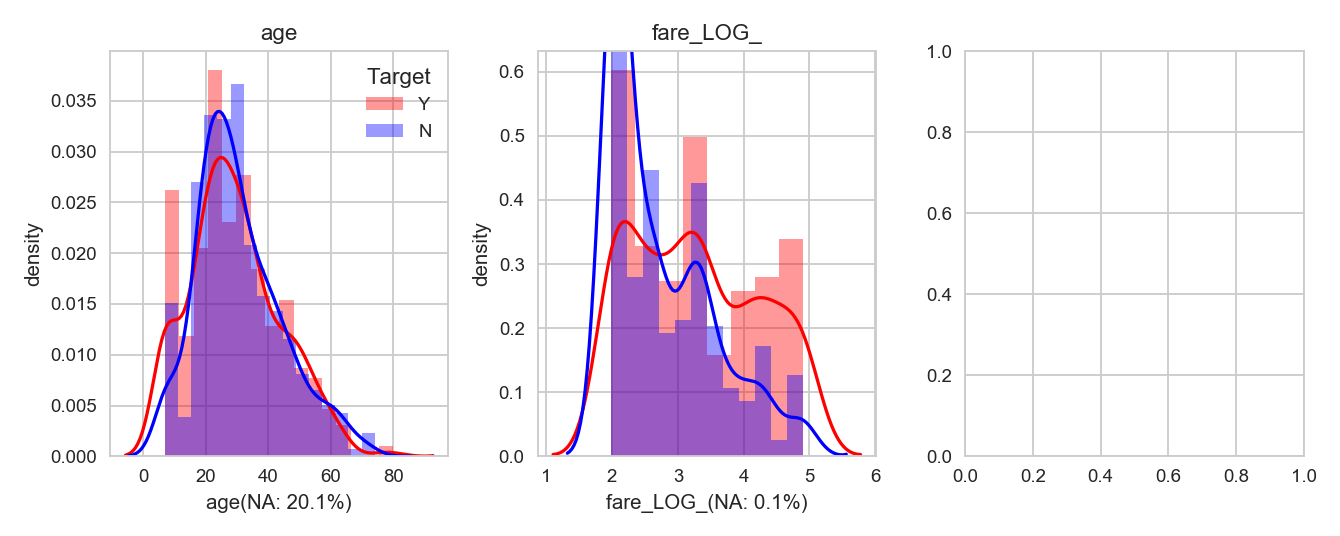

In [14]:
# Final variable information --------------------------------------------------------------------------------------------

# Univariate variable importance: with random imputation!
#todo: (varimp_metr = (filterVarImp(map_df(df[metr], ~ impute(.)), df$target, nonpara = TRUE) %>% rowMeans() %>% 
                  #.[order(., decreasing = TRUE)] %>% round(2)))
    
plt.rcParams['figure.figsize'] = (10.0, 4.0)
fig = get_plot_distr_metr(df, metr, misspct)
fig
fig.savefig(plotloc + "distr_metr_final.pdf")


<IPython.core.display.Javascript object>


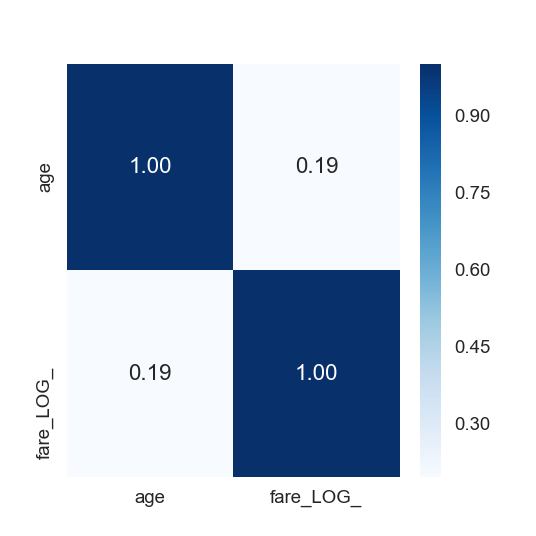

In [15]:
# Removing variables -------------------------------------------------------------------------------------------

# Remove Self features
metr = setdiff(metr, ["xxx"])

# Remove highly/perfectly (>=98%) correlated (the ones with less NA!)
m_corr = abs(df[metr].corr(method = "spearman"))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
fig, ax = plt.subplots(1,1)
fig = sns.heatmap(m_corr, annot=True, fmt=".2f", cmap = "Blues").get_figure()
fig
fig.savefig(plotloc + "corr_metr.pdf")
remove = ["xxx"] #put at xxx the variables to remove
metr = setdiff(metr, remove) #remove
metr_binned = setdiff(metr_binned, [x + "_BINNED_" for x in remove]) #keep "binned" version in sync

In [16]:
# Time/fold depedency --------------------------------------------------------------------------------------------

# Hint: In case of having a detailed date variable this can be used as regression target here as well!

# Univariate variable importance (again ONLY for non-missing observations!)
'''
df$fold_test = factor(ifelse(df$fold == "test", "Y", "N"))
(varimp_metr_fold = filterVarImp(df[metr], df$fold_test, nonpara = TRUE) %>% rowMeans() %>%
    .[order(., decreasing = TRUE)] %>% round(2))

# Plot: only variables with with highest importance
metr_toprint = names(varimp_metr_fold)[varimp_metr_fold >= 0.52]
options(warn = -1)
plots = get_plot_distr_metr(df, metr_toprint, color = c("blue","red"), target_name = "fold_test", 
                            missinfo = misspct, varimpinfo = varimp_metr_fold, ylim = ylim)
ggsave(paste0(plotloc, TYPE, "_distr_metr_final_folddependency.pdf"), marrangeGrob(plots, ncol = 4, nrow = 2), 
       width = 18, height = 12)
options(warn = 0)
'''


'\ndf$fold_test = factor(ifelse(df$fold == "test", "Y", "N"))\n(varimp_metr_fold = filterVarImp(df[metr], df$fold_test, nonpara = TRUE) %>% rowMeans() %>%\n    .[order(., decreasing = TRUE)] %>% round(2))\n\n# Plot: only variables with with highest importance\nmetr_toprint = names(varimp_metr_fold)[varimp_metr_fold >= 0.52]\noptions(warn = -1)\nplots = get_plot_distr_metr(df, metr_toprint, color = c("blue","red"), target_name = "fold_test", \n                            missinfo = misspct, varimpinfo = varimp_metr_fold, ylim = ylim)\nggsave(paste0(plotloc, TYPE, "_distr_metr_final_folddependency.pdf"), marrangeGrob(plots, ncol = 4, nrow = 2), \n       width = 18, height = 12)\noptions(warn = 0)\n'

In [17]:
# Create mising indicators
#(miss = metr[map_lgl(df[metr], ~ any(is.na(.)))])
miss = (np.array(metr)[df[metr].isnull().any().values]).tolist()
df[["MISS_" + x for x in miss]] = pd.DataFrame(np.where(df[miss].isnull(), "miss", "no_miss"))
df[["MISS_" + x for x in miss]].describe()

,MISS_age
count,1309
unique,2
top,no_miss
freq,1046


In [18]:
# Impute missings with randomly sampled value (or median, see below)
#df[miss] = map(df[miss], ~ {
#  i.na = which(is.na(.x))
#  .x[i.na] = sample(.x[-i.na], length(i.na) , replace = TRUE)
#  #.x[i.na] = median(.x[-i.na], na.rm = TRUE) #median imputation
#  .x }
#)
df[miss] = df[miss].fillna(df[miss].median())
df[miss].describe()

,age
count,1309.00000
mean,29.70932
std,12.49690
min,7.00000
25%,22.00000
50%,28.00000
75%,35.00000
max,80.00000


In [19]:
#######################################################################################################################-
#|||| Nominal variables: Explore and adapt ||||----
#######################################################################################################################-

# Define nominal covariates -------------------------------------------------------------------------------------

if TYPE == "CLASS": 
    nomi = ["pclass","sex","sibsp","parch","deck","embarked","boat","home.dest"]
if TYPE in ["REGR","MULTICLASS"]:
   nomi = ["MS_SubClass","MS_Zoning","Street","Alley","Lot_Shape","Land_Contour","Utilities","Lot_Config","Land_Slope",
           "Neighborhood","Condition_1","Condition_2","Bldg_Type","House_Style","Overall_Qual","Overall_Cond",
           "Roof_Style","Roof_Matl","Exterior_1st","Exterior_2nd","Mas_Vnr_Type","Exter_Qual","Exter_Cond","Foundation",
           "Bsmt_Qual","Bsmt_Cond","Bsmt_Exposure","BsmtFin_Type_1","BsmtFin_Type_2","Heating","Heating_QC","Central_Air",
           "Electrical","Bsmt_Full_Bath","Bsmt_Half_Bath","Full_Bath","Half_Bath","Bedroom_AbvGr","Kitchen_AbvGr",
           "Kitchen_Qual","TotRms_AbvGrd","Functional","Fireplaces","Fireplace_Qu","Garage_Type","Garage_Finish",
           "Garage_Cars","Garage_Qual","Garage_Cond","Paved_Drive","Pool_QC","Fence","Misc_Feature","Mo_Sold","Yr_Sold",
           "Sale_Type","Sale_Condition"]

nomi = nomi + ["MISS_" + x for x in miss] #add missing indicators
df[nomi] = df[nomi].astype(object) #map to string
df[nomi].describe(include = "all")


,pclass,sex,sibsp,parch,deck,embarked,boat,home.dest,MISS_age
count,1309,1309,1309,1309,295,1307,486,745,1309
unique,3,2,7,8,8,3,27,368,2
top,3rd,male,0,0,C,Southampton,13,"New York, NY",no_miss
freq,709,843,891,1002,94,914,39,64,1046


In [20]:
# Handling factor values ----------------------------------------------------------------------------------------------

# Convert missings to own level ("(Missing)")
df[nomi] = df[nomi].fillna("(Missing)", downcast = False)
df[nomi].describe(include = "all")

,pclass,sex,sibsp,parch,deck,embarked,boat,home.dest,MISS_age
count,1309,1309,1309,1309,1309,1309,1309,1309,1309
unique,3,2,7,8,9,4,28,369,2
top,3rd,male,0,0,(Missing),Southampton,(Missing),(Missing),no_miss
freq,709,843,891,1002,1014,914,823,564,1046


In [21]:
'''
# Reorder "numeric" nominal variables
if TYPE == "CLASS":
    ord = ["sibsp", "parch"]
if TYPE in ["REGR","MULTICLASS"]:
    ord = ["MS_SubClass","Overall_Qual","Overall_Cond","Bedroom_AbvGr","TotRms_AbvGrd","Mo_Sold"]
df[ord] =  map(df[ord], ~ fct_relevel(., levels(.)[order(as.numeric(levels(.)), na.last = FALSE)]))
'''

'\n# Reorder "numeric" nominal variables\nif TYPE == "CLASS":\n    ord = ["sibsp", "parch"]\nif TYPE in ["REGR","MULTICLASS"]:\n    ord = ["MS_SubClass","Overall_Qual","Overall_Cond","Bedroom_AbvGr","TotRms_AbvGrd","Mo_Sold"]\ndf[ord] =  map(df[ord], ~ fct_relevel(., levels(.)[order(as.numeric(levels(.)), na.last = FALSE)]))\n'

In [22]:
# Create compact covariates for "too many members" columns 
topn_toomany = 10
levinfo = (df[nomi].apply(lambda x: x.unique().size)).sort_values(ascending = False)
toomany = levinfo[levinfo > topn_toomany].index.values.tolist(); print(toomany)
toomany = setdiff(toomany, ["xxx"]) #set exception for important variables
df[[x + "_OTHER_" for x in toomany]] = df[toomany].apply(lambda x: 
    x.replace(x.value_counts()[topn_toomany:].index.values, "_OTHER_")) #collapse
nomi = [x + "_OTHER_" if x in toomany else x for x in nomi] #adapt metadata (keep order)
df[[x + "_OTHER_" for x in toomany]].apply(lambda x: print(x.value_counts())) #check

['home.dest', 'boat']
_OTHER_                            608
(Missing)                          564
New York, NY                        64
London                              14
Montreal, PQ                        10
Paris, France                        9
Cornwall / Akron, OH                 9
Winnipeg, MB                         8
Philadelphia, PA                     8
Wiltshire, England Niagara Fall      8
Brooklyn, NY                         7
Name: home.dest_OTHER_, dtype: int64
(Missing)    823
_OTHER_      201
13            39
C             38
15            37
14            33
4             31
10            29
5             27
3             26
9             25
Name: boat_OTHER_, dtype: int64


home.dest_OTHER_    None
boat_OTHER_         None
dtype: object

In [23]:
# TODO
'''
# Univariate variable importance
#varimp = filterVarImp(df[nomi], df$target, nonpara = TRUE) %>% 
  #mutate(Y = round(ifelse(Y < 0.5, 1 - Y, Y),2)) %>% .$Y
'''

'\n# Univariate variable importance\n#varimp = filterVarImp(df[nomi], df$target, nonpara = TRUE) %>% \n  #mutate(Y = round(ifelse(Y < 0.5, 1 - Y, Y),2)) %>% .$Y\n'

In [ ]:
def get_plot_distr_nomi(df_plot, features):
    fig, ax = plt.subplots(len(features) // 3, 3)
    for i in range(len(features)):
        df_tmp = pd.DataFrame({"h": df_plot.groupby(features[i])["target_num"].mean(), 
                               "w": df_plot.groupby(features[i]).size()}).reset_index()
        df_tmp["w"] = df_tmp["w"]/max(df_tmp["w"])
        axact = ax.flat[i]
        sns.barplot(df_tmp.h, df_tmp[features[i]], orient = "h", color = "coral", ax = axact, edcolor = "black").set_title(features[i])
        axact.set_xlabel("Proportion Target = Y")
        axact.set_ylabel("")
        axact.axvline(np.mean(df_plot.target_num), ls = "dotted", color = "black")
        for bar,width in zip(axact.patches, df_tmp.w):
            y = bar.get_y()
            oldwidth = bar.get_height()
            bar.set_y(y + oldwidth/2 - width/2)
            #bar.set_width(newwidth)
            bar.set_height(width)            
    fig.tight_layout()
    return(fig)
# Check
plt.rcParams['figure.figsize'] = (10, 10)
fig = get_plot_distr_nomi(df, nomi)
fig
fig.savefig(plotloc + "distr_nomi.pdf")


In [29]:
nomi

['pclass',
 'sex',
 'sibsp',
 'parch',
 'deck',
 'embarked',
 'boat_OTHER_',
 'home.dest_OTHER_',
 'MISS_age']

In [159]:

# Removing variables ----------------------------------------------------------------------------------------------

# Remove Self-features
if TYPE == "CLASS": 
    nomi = setdiff(nomi, ["boat_OTHER_"])
#if (TYPE %in% c("REGR","MULTICLASS")) nomi = setdiff(nomi, "xxx")

'''
# Remove highly/perfectly (>=99%) correlated (the ones with less levels!) 
plot = get_plot_corr(df, input_type = "nomi",  vars = setdiff(nomi, paste0("MISS_",miss)), cutoff = cutoff)
ggsave(paste0(plotloc,TYPE,"_corr_nomi.pdf"), plot, width = 9, height = 9)
if (TYPE %in% c("REGR","MULTICLASS")) {
  plot = get_plot_corr(df, input_type = "nomi",  vars = paste0("MISS_",miss), cutoff = 0.98)
  ggsave(paste0(plotloc,TYPE,"_corr_nomi_MISS.pdf"), plot, width = 9, height = 9)
  nomi = setdiff(nomi, c("MISS_BsmtFin_SF_2","MISS_BsmtFin_SF_1","MISS_second_Flr_SF","MISS_Misc_Val_LOG_",
                        "MISS_Mas_Vnr_Area","MISS_Garage_Yr_Blt","MISS_Garage_Area","MISS_Total_Bsmt_SF"))
}




# Time/fold depedency --------------------------------------------------------------------------------------------

# Hint: In case of having a detailed date variable this can be used as regression target here as well!

# Univariate variable importance
(varimp_nomi_fold = filterVarImp(df[nomi], df$fold_test, nonpara = TRUE) %>% rowMeans() %>% 
   .[order(., decreasing = TRUE)] %>% round(2))

# Plot (Hint: one might want to filter just on variable importance with highest importance)
nomi_toprint = names(varimp_nomi_fold)[varimp_nomi_fold >= 0.52]
plots = get_plot_distr_nomi(df, nomi_toprint, color = c("blue","red"), target_name = "fold_test", inner_barplot = FALSE,
                            varimpinfo = varimp_nomi_fold, ylim = ylim)
ggsave(paste0(plotloc,TYPE,"_distr_nomi_folddependency.pdf"), marrangeGrob(plots, ncol = 4, nrow = 3), 
       width = 18, height = 12)

'''

'\n# Removing variables ----------------------------------------------------------------------------------------------\n\n# Remove Self-features\nif (TYPE == "CLASS") nomi = setdiff(nomi, "boat_OTHER_")\nif (TYPE %in% c("REGR","MULTICLASS")) nomi = setdiff(nomi, "xxx")\n\n# Remove highly/perfectly (>=99%) correlated (the ones with less levels!) \nplot = get_plot_corr(df, input_type = "nomi",  vars = setdiff(nomi, paste0("MISS_",miss)), cutoff = cutoff)\nggsave(paste0(plotloc,TYPE,"_corr_nomi.pdf"), plot, width = 9, height = 9)\nif (TYPE %in% c("REGR","MULTICLASS")) {\n  plot = get_plot_corr(df, input_type = "nomi",  vars = paste0("MISS_",miss), cutoff = 0.98)\n  ggsave(paste0(plotloc,TYPE,"_corr_nomi_MISS.pdf"), plot, width = 9, height = 9)\n  nomi = setdiff(nomi, c("MISS_BsmtFin_SF_2","MISS_BsmtFin_SF_1","MISS_second_Flr_SF","MISS_Misc_Val_LOG_",\n                        "MISS_Mas_Vnr_Area","MISS_Garage_Yr_Blt","MISS_Garage_Area","MISS_Total_Bsmt_SF"))\n}\n\n\n\n\n# Time/fold depedenc

In [165]:
#######################################################################################################################-
#|||| Prepare final data ||||----
#######################################################################################################################-

# Define final predictors ----------------------------------------------------------------------------------------

predictors = metr + nomi
predictors_binned = metr_binned + setdiff(nomi, ["MISS_" + x for x in miss]) #do not need indicators if binned variables

# Check
df[predictors].describe(include = "all")
setdiff(predictors, df.columns.values)
df[predictors_binned].describe(include = "all")
setdiff(predictors_binned, df.columns.values)



# Save image ----------------------------------------------------------------------------------------------------------

#del df_orig
dill.dump_session("../1_explore.pkl") 


,age,fare_LOG_,pclass,sex,sibsp,parch,deck,embarked,home.dest_OTHER_,MISS_age
count,1309.00000,1309.000000,1309,1309,1309.0,1309.0,1309,1309,1309,1309
unique,NaN,NaN,3,2,7.0,8.0,9,4,11,2
top,NaN,NaN,3rd,male,0.0,0.0,(Missing),Southampton,_OTHER_,no_miss
freq,NaN,NaN,709,843,891.0,1002.0,1014,914,608,1046
mean,29.70932,2.919945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,12.49690,0.900016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,7.00000,1.977547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,22.00000,2.066331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,28.00000,2.670985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,35.00000,3.442819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[]

,age_BINNED_,fare_BINNED_,pclass,sex,sibsp,parch,deck,embarked,home.dest_OTHER_
count,1309,1309,1309,1309,1309,1309,1309,1309,1309
unique,11,11,3,2,7,8,9,4,11
top,nan,"(7.854, 8.05]",3rd,male,0,0,(Missing),Southampton,_OTHER_
freq,263,146,709,843,891,1002,1014,914,608


[]